In [3]:
import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Loading data

In [4]:
DATA_PATH = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv'

# Adjust these column names as needed.
date_col = 'time'
target_col = 'KarupBro'
# List of meteorological features from DMI – update if needed.
input_cols = [
    'temp_min_daily', 'temp_max_daily', 'temp_mean_daily', 
    'temp_grass_mean_daily', 'temp_soil_min_daily', 'temp_soil_max_daily', 
    'temp_soil_mean_daily', 'humidity_daily', 'wind_direction_daily', 
    'wind_speed_daily', 'wind_gust_max_daily', 'precip_total_daily', 
    'precip_duration_daily', 'radiation_global_daily', 
    'sunshine_duration_daily'
]


# Read the CSV
df = pd.read_csv(DATA_PATH, parse_dates=[date_col])
df.sort_values(date_col, inplace=True)
df.reset_index(drop=True, inplace=True)

# Optional: Set the date column as index (if needed)
df.set_index(date_col, inplace=True)

df.tail()

,temp_min_daily,temp_max_daily,temp_mean_daily,temp_grass_mean_daily,temp_soil_min_daily,temp_soil_max_daily,temp_soil_mean_daily,humidity_daily,wind_direction_daily,wind_speed_daily,wind_gust_max_daily,precip_total_daily,precip_duration_daily,radiation_global_daily,sunshine_duration_daily,KarupBro
time,,,,,,,,,,,,,,,,
2024-12-27,4.0,6.0,5.250000,2.016421,6.6,7.4,6.941667,97.250000,223.583333,1.966667,6.0,0.0,0.0,131.0,12.0,NaN
2024-12-28,3.3,5.1,4.116667,1.946083,6.1,6.9,6.445833,97.666667,217.708333,3.050000,7.7,0.0,0.0,188.0,25.0,NaN
2024-12-29,4.5,8.4,7.133333,1.524006,6.1,7.4,6.812500,91.958333,231.291667,6.154167,15.4,0.1,0.0,210.0,26.0,NaN
2024-12-30,7.7,8.9,8.179167,2.204877,7.1,7.9,7.466667,91.041667,236.416667,8.741667,16.7,2.9,0.0,87.0,0.0,NaN
2024-12-31,7.9,8.6,8.300000,1.909754,7.5,7.8,7.600000,85.000000,261.000000,9.400000,16.4,0.0,0.0,0.0,0.0,NaN


In [5]:
# Check for missing values
df.isnull().sum()

temp_min_daily               0
temp_max_daily               0
temp_mean_daily              0
temp_grass_mean_daily        0
temp_soil_min_daily          0
temp_soil_max_daily          0
temp_soil_mean_daily         0
humidity_daily               0
wind_direction_daily         0
wind_speed_daily             0
wind_gust_max_daily          0
precip_total_daily           0
precip_duration_daily        0
radiation_global_daily       0
sunshine_duration_daily      0
KarupBro                   366
dtype: int64

In [6]:
# Forward fill and check again
df = df.iloc[:-366]
df.isnull().sum()

temp_min_daily             0
temp_max_daily             0
temp_mean_daily            0
temp_grass_mean_daily      0
temp_soil_min_daily        0
temp_soil_max_daily        0
temp_soil_mean_daily       0
humidity_daily             0
wind_direction_daily       0
wind_speed_daily           0
wind_gust_max_daily        0
precip_total_daily         0
precip_duration_daily      0
radiation_global_daily     0
sunshine_duration_daily    0
KarupBro                   0
dtype: int64

## Filtering data to simple model

In [7]:
df_simple = df[["temp_mean_daily", "precip_total_daily", "KarupBro"]]
df_simple.head()

,temp_mean_daily,precip_total_daily,KarupBro
time,,,
2002-01-01,1.250000,2.2,1829.75
2002-01-02,-0.837500,0.0,7279.46
2002-01-03,-5.166667,0.0,5261.85
2002-01-04,-6.025000,0.0,2951.97
2002-01-05,-3.466667,0.1,1868.53


<Axes: xlabel='time'>

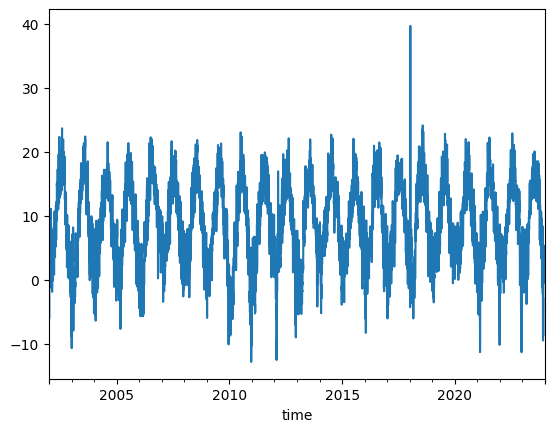

In [8]:
temp = df['temp_mean_daily']
temp.plot()

In [9]:
# Replace outliers with NaN
df.loc[df["temp_mean_daily"] > 35, "temp_mean_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["temp_mean_daily"] = df["temp_mean_daily"].ffill()

<Axes: xlabel='time'>

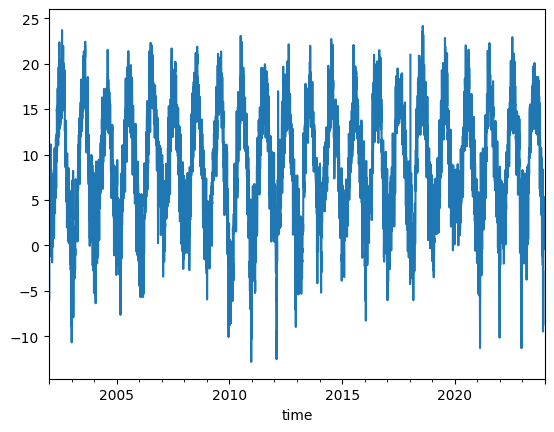

In [10]:
temp.plot()

<Axes: xlabel='time'>

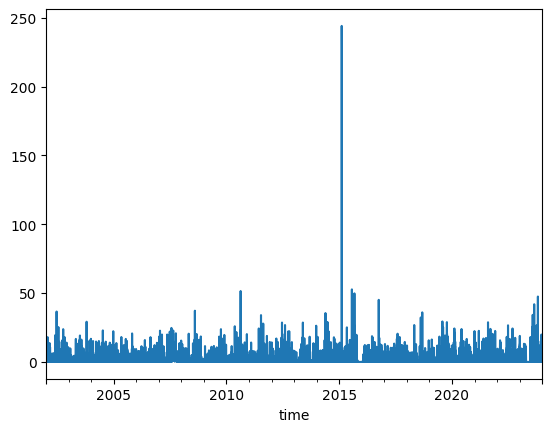

In [11]:
rain = df['precip_total_daily']
rain.plot()

In [12]:
import numpy as np

# Replace outliers with NaN
df.loc[df["precip_total_daily"] > 100, "precip_total_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["precip_total_daily"] = df["precip_total_daily"].ffill()

<Axes: xlabel='time'>

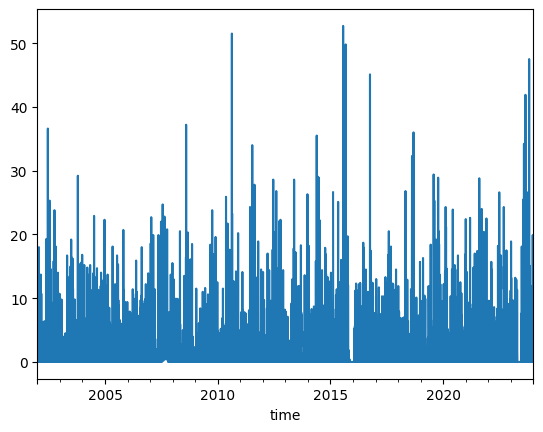

In [13]:
rain.plot()

<Axes: xlabel='time'>

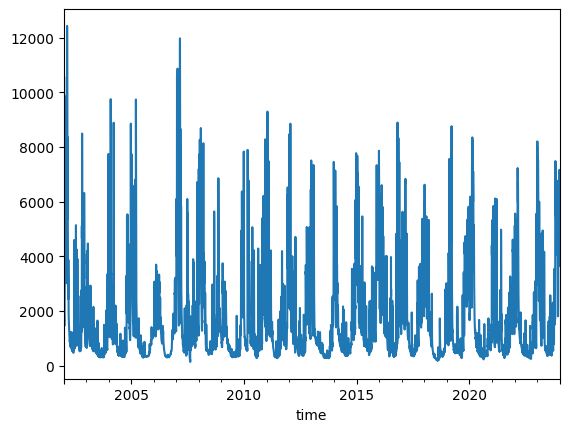

In [14]:
inflow = df['KarupBro']
inflow.plot()

In [15]:
def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [16]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(inflow, WINDOW_SIZE)
X1.shape, y1.shape

((8030, 5, 1), (8030,))

In [17]:
X_train1, y_train1 = X1[:6000], y1[:6000]
X_val1, y_val1 = X1[6000:7000], y1[6000:7000]
X_test1, y_test1 = X1[7000:], y1[7000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((6000, 5, 1), (6000,), (1000, 5, 1), (1000,), (1030, 5, 1), (1030,))

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [20]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp1])

Epoch 1/50
166/188 [=========================>....] - ETA: 0s - loss: 5514703.5000 - root_mean_squared_error: 2348.3406INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 2s 8ms/step - loss: 5462185.0000 - root_mean_squared_error: 2337.1318 - val_loss: 5493462.0000 - val_root_mean_squared_error: 2343.8135
Epoch 2/50
174/188 [==========================>...] - ETA: 0s - loss: 5426334.0000 - root_mean_squared_error: 2329.4492INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 8ms/step - loss: 5415974.0000 - root_mean_squared_error: 2327.2246 - val_loss: 5432716.0000 - val_root_mean_squared_error: 2330.8188
Epoch 3/50
174/188 [==========================>...] - ETA: 0s - loss: 5346852.5000 - root_mean_squared_error: 2312.3262INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5327895.0000 - root_mean_squared_error: 2308.2234 - val_loss: 5328306.5000 - val_root_mean_squared_error: 2308.3125
Epoch 4/50
168/188 [=========================>....] - ETA: 0s - loss: 5328772.0000 - root_mean_squared_error: 2308.4133INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5199578.0000 - root_mean_squared_error: 2280.2583 - val_loss: 5187804.5000 - val_root_mean_squared_error: 2277.6753
Epoch 5/50
168/188 [=========================>....] - ETA: 0s - loss: 5048814.0000 - root_mean_squared_error: 2246.9565INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5036495.5000 - root_mean_squared_error: 2244.2139 - val_loss: 5017086.0000 - val_root_mean_squared_error: 2239.8853
Epoch 6/50
173/188 [==========================>...] - ETA: 0s - loss: 4824488.5000 - root_mean_squared_error: 2196.4719INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 2s 8ms/step - loss: 4842077.0000 - root_mean_squared_error: 2200.4719 - val_loss: 4831523.5000 - val_root_mean_squared_error: 2198.0728
Epoch 7/50
172/188 [==========================>...] - ETA: 0s - loss: 4649906.5000 - root_mean_squared_error: 2156.3643INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 4634603.0000 - root_mean_squared_error: 2152.8127 - val_loss: 4630575.0000 - val_root_mean_squared_error: 2151.8772
Epoch 8/50
179/188 [===========================>..] - ETA: 0s - loss: 4380732.5000 - root_mean_squared_error: 2093.0200INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 4421930.0000 - root_mean_squared_error: 2102.8386 - val_loss: 4433111.5000 - val_root_mean_squared_error: 2105.4956
Epoch 9/50
175/188 [==========================>...] - ETA: 0s - loss: 4268140.0000 - root_mean_squared_error: 2065.9478INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 8ms/step - loss: 4210966.0000 - root_mean_squared_error: 2052.0637 - val_loss: 4239343.5000 - val_root_mean_squared_error: 2058.9666
Epoch 10/50
181/188 [===========================>..] - ETA: 0s - loss: 4000368.0000 - root_mean_squared_error: 2000.0920INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 4004929.2500 - root_mean_squared_error: 2001.2319 - val_loss: 4054062.5000 - val_root_mean_squared_error: 2013.4702
Epoch 11/50
180/188 [===========================>..] - ETA: 0s - loss: 3811226.2500 - root_mean_squared_error: 1952.2362INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 3807349.5000 - root_mean_squared_error: 1951.2430 - val_loss: 3871771.5000 - val_root_mean_squared_error: 1967.6818
Epoch 12/50
175/188 [==========================>...] - ETA: 0s - loss: 3612522.5000 - root_mean_squared_error: 1900.6637INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 3614161.0000 - root_mean_squared_error: 1901.0947 - val_loss: 3688403.7500 - val_root_mean_squared_error: 1920.5217
Epoch 13/50
175/188 [==========================>...] - ETA: 0s - loss: 3406341.5000 - root_mean_squared_error: 1845.6277INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 8ms/step - loss: 3425483.7500 - root_mean_squared_error: 1850.8063 - val_loss: 3506452.2500 - val_root_mean_squared_error: 1872.5524
Epoch 14/50
164/188 [=========================>....] - ETA: 0s - loss: 3214711.2500 - root_mean_squared_error: 1792.9615INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 3245777.5000 - root_mean_squared_error: 1801.6041 - val_loss: 3344736.0000 - val_root_mean_squared_error: 1828.8619
Epoch 15/50
181/188 [===========================>..] - ETA: 0s - loss: 3090788.5000 - root_mean_squared_error: 1758.0638INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 3079889.0000 - root_mean_squared_error: 1754.9613 - val_loss: 3186593.5000 - val_root_mean_squared_error: 1785.1033
Epoch 16/50
182/188 [============================>.] - ETA: 0s - loss: 2953697.7500 - root_mean_squared_error: 1718.6326INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 2921016.0000 - root_mean_squared_error: 1709.0980 - val_loss: 3034683.2500 - val_root_mean_squared_error: 1742.0342
Epoch 17/50
179/188 [===========================>..] - ETA: 0s - loss: 2707761.7500 - root_mean_squared_error: 1645.5278INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 8ms/step - loss: 2764833.0000 - root_mean_squared_error: 1662.7787 - val_loss: 2870584.0000 - val_root_mean_squared_error: 1694.2798
Epoch 18/50
165/188 [=========================>....] - ETA: 0s - loss: 2628915.7500 - root_mean_squared_error: 1621.3932INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 2613848.7500 - root_mean_squared_error: 1616.7401 - val_loss: 2699125.2500 - val_root_mean_squared_error: 1642.9015
Epoch 19/50
180/188 [===========================>..] - ETA: 0s - loss: 2461399.0000 - root_mean_squared_error: 1568.8846INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 2457737.2500 - root_mean_squared_error: 1567.7172 - val_loss: 2540270.5000 - val_root_mean_squared_error: 1593.8226
Epoch 20/50
174/188 [==========================>...] - ETA: 0s - loss: 2305041.0000 - root_mean_squared_error: 1518.2362INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 8ms/step - loss: 2315842.5000 - root_mean_squared_error: 1521.7892 - val_loss: 2389345.0000 - val_root_mean_squared_error: 1545.7506
Epoch 21/50
167/188 [=========================>....] - ETA: 0s - loss: 2146187.2500 - root_mean_squared_error: 1464.9871INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 2181076.2500 - root_mean_squared_error: 1476.8467 - val_loss: 2245470.0000 - val_root_mean_squared_error: 1498.4893
Epoch 22/50
170/188 [==========================>...] - ETA: 0s - loss: 2054048.2500 - root_mean_squared_error: 1433.1951INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 2052213.7500 - root_mean_squared_error: 1432.5549 - val_loss: 2097541.5000 - val_root_mean_squared_error: 1448.2892
Epoch 23/50
181/188 [===========================>..] - ETA: 0s - loss: 1932591.7500 - root_mean_squared_error: 1390.1769INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 1927066.2500 - root_mean_squared_error: 1388.1881 - val_loss: 1962916.5000 - val_root_mean_squared_error: 1401.0413
Epoch 24/50
174/188 [==========================>...] - ETA: 0s - loss: 1825279.1250 - root_mean_squared_error: 1351.0289INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 2s 8ms/step - loss: 1815147.5000 - root_mean_squared_error: 1347.2740 - val_loss: 1860127.6250 - val_root_mean_squared_error: 1363.8650
Epoch 25/50
172/188 [==========================>...] - ETA: 0s - loss: 1702460.2500 - root_mean_squared_error: 1304.7836INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 1711056.8750 - root_mean_squared_error: 1308.0737 - val_loss: 1731237.0000 - val_root_mean_squared_error: 1315.7648
Epoch 26/50
177/188 [===========================>..] - ETA: 0s - loss: 1640044.8750 - root_mean_squared_error: 1280.6423INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 1613647.5000 - root_mean_squared_error: 1270.2943 - val_loss: 1613883.1250 - val_root_mean_squared_error: 1270.3870
Epoch 27/50
176/188 [===========================>..] - ETA: 0s - loss: 1515375.7500 - root_mean_squared_error: 1231.0060INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 1516099.1250 - root_mean_squared_error: 1231.2998 - val_loss: 1540366.7500 - val_root_mean_squared_error: 1241.1151
Epoch 28/50
177/188 [===========================>..] - ETA: 0s - loss: 1399262.6250 - root_mean_squared_error: 1182.9043INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 8ms/step - loss: 1424871.5000 - root_mean_squared_error: 1193.6798 - val_loss: 1409789.7500 - val_root_mean_squared_error: 1187.3457
Epoch 29/50
164/188 [=========================>....] - ETA: 0s - loss: 1356948.0000 - root_mean_squared_error: 1164.8811INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 1338768.7500 - root_mean_squared_error: 1157.0518 - val_loss: 1316157.0000 - val_root_mean_squared_error: 1147.2389
Epoch 30/50
179/188 [===========================>..] - ETA: 0s - loss: 1251103.8750 - root_mean_squared_error: 1118.5276INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 1267088.0000 - root_mean_squared_error: 1125.6500 - val_loss: 1238795.3750 - val_root_mean_squared_error: 1113.0118
Epoch 31/50
175/188 [==========================>...] - ETA: 0s - loss: 1192000.5000 - root_mean_squared_error: 1091.7877INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 8ms/step - loss: 1192835.8750 - root_mean_squared_error: 1092.1703 - val_loss: 1123907.1250 - val_root_mean_squared_error: 1060.1449
Epoch 32/50
180/188 [===========================>..] - ETA: 0s - loss: 1126085.5000 - root_mean_squared_error: 1061.1718INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 1123533.2500 - root_mean_squared_error: 1059.9685 - val_loss: 1061490.5000 - val_root_mean_squared_error: 1030.2866
Epoch 33/50
182/188 [============================>.] - ETA: 0s - loss: 1067257.7500 - root_mean_squared_error: 1033.0817INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 1056838.7500 - root_mean_squared_error: 1028.0266 - val_loss: 965417.4375 - val_root_mean_squared_error: 982.5566
Epoch 34/50
162/188 [========================>.....] - ETA: 0s - loss: 1002865.8750 - root_mean_squared_error: 1001.4319INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 994754.3125 - root_mean_squared_error: 997.3737 - val_loss: 893479.9375 - val_root_mean_squared_error: 945.2407
Epoch 35/50
176/188 [===========================>..] - ETA: 0s - loss: 961654.6250 - root_mean_squared_error: 980.6399  INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 2s 8ms/step - loss: 938706.1875 - root_mean_squared_error: 968.8685 - val_loss: 831747.2500 - val_root_mean_squared_error: 912.0018
Epoch 36/50
179/188 [===========================>..] - ETA: 0s - loss: 893382.4375 - root_mean_squared_error: 945.1891INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 887954.9375 - root_mean_squared_error: 942.3136 - val_loss: 784782.3125 - val_root_mean_squared_error: 885.8794
Epoch 37/50
171/188 [==========================>...] - ETA: 0s - loss: 820377.0625 - root_mean_squared_error: 905.7467INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 841796.6250 - root_mean_squared_error: 917.4948 - val_loss: 722956.1875 - val_root_mean_squared_error: 850.2683
Epoch 38/50
176/188 [===========================>..] - ETA: 0s - loss: 830813.7500 - root_mean_squared_error: 911.4899INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 824796.9375 - root_mean_squared_error: 908.1833 - val_loss: 709813.5625 - val_root_mean_squared_error: 842.5043
Epoch 39/50
188/188 [==============================] - 0s 2ms/step - loss: 814094.8750 - root_mean_squared_error: 902.2720 - val_loss: 716679.7500 - val_root_mean_squared_error: 846.5694
Epoch 40/50
175/188 [==========================>...] - ETA: 0s - loss: 818395.5000 - root_mean_squared_error: 904.6522INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 2s 8ms/step - loss: 793346.8125 - root_mean_squared_error: 890.7002 - val_loss: 665798.0625 - val_root_mean_squared_error: 815.9645
Epoch 41/50
178/188 [===========================>..] - ETA: 0s - loss: 754862.9375 - root_mean_squared_error: 868.8285INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 758036.5000 - root_mean_squared_error: 870.6529 - val_loss: 632209.8750 - val_root_mean_squared_error: 795.1163
Epoch 42/50
179/188 [===========================>..] - ETA: 0s - loss: 734789.8750 - root_mean_squared_error: 857.1989INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 722661.3750 - root_mean_squared_error: 850.0949 - val_loss: 592535.2500 - val_root_mean_squared_error: 769.7631
Epoch 43/50
188/188 [==============================] - 0s 2ms/step - loss: 695391.9375 - root_mean_squared_error: 833.9016 - val_loss: 632685.3750 - val_root_mean_squared_error: 795.4152
Epoch 44/50
181/188 [===========================>..] - ETA: 0s - loss: 708801.3125 - root_mean_squared_error: 841.9034INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 704919.1875 - root_mean_squared_error: 839.5947 - val_loss: 575307.9375 - val_root_mean_squared_error: 758.4905
Epoch 45/50
173/188 [==========================>...] - ETA: 0s - loss: 668320.1250 - root_mean_squared_error: 817.5085INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 8ms/step - loss: 670460.6875 - root_mean_squared_error: 818.8167 - val_loss: 528071.3125 - val_root_mean_squared_error: 726.6852
Epoch 46/50
188/188 [==============================] - 0s 2ms/step - loss: 671523.8125 - root_mean_squared_error: 819.4656 - val_loss: 543390.3750 - val_root_mean_squared_error: 737.1501
Epoch 47/50
184/188 [============================>.] - ETA: 0s - loss: 676063.3125 - root_mean_squared_error: 822.2307INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 674524.7500 - root_mean_squared_error: 821.2946 - val_loss: 520394.5938 - val_root_mean_squared_error: 721.3838
Epoch 48/50
188/188 [==============================] - 0s 2ms/step - loss: 652346.6875 - root_mean_squared_error: 807.6798 - val_loss: 555783.6250 - val_root_mean_squared_error: 745.5090
Epoch 49/50
180/188 [===========================>..] - ETA: 0s - loss: 657213.7500 - root_mean_squared_error: 810.6872INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 649223.0000 - root_mean_squared_error: 805.7438 - val_loss: 487682.7188 - val_root_mean_squared_error: 698.3428
Epoch 50/50
188/188 [==============================] - 0s 2ms/step - loss: 629926.3750 - root_mean_squared_error: 793.6790 - val_loss: 500867.4688 - val_root_mean_squared_error: 707.7199


In [21]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [ ]:
from sklearn.metrics import root_mean_squared_error as rmse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, rmse(predictions, y)

33/33 [==============================] - 0s 731us/step


(      Predictions  Actuals
 0     1102.664795  1015.35
 1     1059.624268   905.19
 2      952.546021   862.98
 3      902.462341   832.00
 4      877.966980  3217.89
 ...           ...      ...
 1025  4437.940918  5197.40
 1026  4430.281250  6368.46
 1027  4438.378906  7162.01
 1028  4438.382812  6869.41
 1029  4438.382812  6335.36
 
 [1030 rows x 2 columns],
 727.4132943708966)

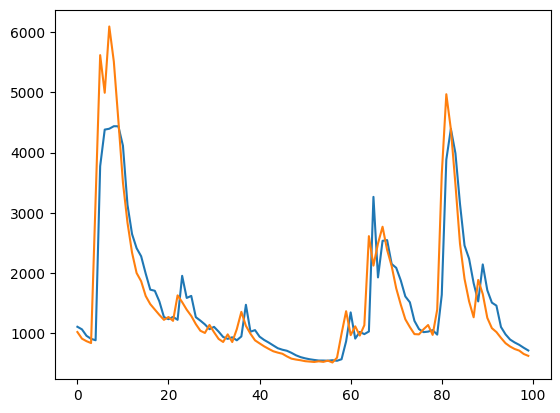

In [23]:
plot_predictions1(model1, X_test1, y_test1)

## Conv1D model

In [24]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2, activation='relu'))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             192       
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 2056      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2257 (8.82 KB)
Trainable params: 2257 (8.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [26]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp2])

Epoch 1/50
 87/188 [============>.................] - ETA: 0s - loss: 1441450.0000 - root_mean_squared_error: 1200.6040  INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


188/188 [==============================] - 1s 2ms/step - loss: 1043390.8125 - root_mean_squared_error: 1021.4650 - val_loss: 333985.5938 - val_root_mean_squared_error: 577.9149
Epoch 2/50
112/188 [================>.............] - ETA: 0s - loss: 438832.7812 - root_mean_squared_error: 662.4446INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


188/188 [==============================] - 0s 1ms/step - loss: 390132.0625 - root_mean_squared_error: 624.6055 - val_loss: 172365.0156 - val_root_mean_squared_error: 415.1687
Epoch 3/50
188/188 [==============================] - 0s 629us/step - loss: 334550.0938 - root_mean_squared_error: 578.4031 - val_loss: 197843.8906 - val_root_mean_squared_error: 444.7964
Epoch 4/50
188/188 [==============================] - 0s 578us/step - loss: 333143.2812 - root_mean_squared_error: 577.1857 - val_loss: 177214.2344 - val_root_mean_squared_error: 420.9682
Epoch 5/50
112/188 [================>.............] - ETA: 0s - loss: 290752.7500 - root_mean_squared_error: 539.2150INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


188/188 [==============================] - 0s 1ms/step - loss: 326904.1562 - root_mean_squared_error: 571.7553 - val_loss: 158057.4844 - val_root_mean_squared_error: 397.5645
Epoch 6/50
188/188 [==============================] - 0s 581us/step - loss: 323849.6562 - root_mean_squared_error: 569.0779 - val_loss: 162341.8906 - val_root_mean_squared_error: 402.9167
Epoch 7/50
188/188 [==============================] - 0s 661us/step - loss: 321383.4062 - root_mean_squared_error: 566.9069 - val_loss: 175262.5781 - val_root_mean_squared_error: 418.6437
Epoch 8/50
188/188 [==============================] - 0s 775us/step - loss: 325593.8125 - root_mean_squared_error: 570.6083 - val_loss: 176466.3125 - val_root_mean_squared_error: 420.0789
Epoch 9/50
188/188 [==============================] - 0s 595us/step - loss: 324947.5938 - root_mean_squared_error: 570.0417 - val_loss: 166930.2344 - val_root_mean_squared_error: 408.5710
Epoch 10/50
103/188 [===============>..............] - ETA: 0s - loss: 29

INFO:tensorflow:Assets written to: model2/assets


188/188 [==============================] - 0s 2ms/step - loss: 318956.5625 - root_mean_squared_error: 564.7624 - val_loss: 156650.5781 - val_root_mean_squared_error: 395.7911
Epoch 11/50
188/188 [==============================] - 0s 581us/step - loss: 315222.5000 - root_mean_squared_error: 561.4468 - val_loss: 164340.0156 - val_root_mean_squared_error: 405.3887
Epoch 12/50
188/188 [==============================] - 0s 607us/step - loss: 316273.7188 - root_mean_squared_error: 562.3822 - val_loss: 164530.7656 - val_root_mean_squared_error: 405.6239
Epoch 13/50
188/188 [==============================] - 0s 568us/step - loss: 315034.5000 - root_mean_squared_error: 561.2794 - val_loss: 166495.6875 - val_root_mean_squared_error: 408.0388
Epoch 14/50
188/188 [==============================] - 0s 568us/step - loss: 316267.9062 - root_mean_squared_error: 562.3770 - val_loss: 182882.0312 - val_root_mean_squared_error: 427.6471
Epoch 15/50
188/188 [==============================] - 0s 564us/step 

33/33 [==============================] - 0s 398us/step


(      Predictions  Actuals
 0     1129.189331  1015.35
 1     1142.062134   905.19
 2      903.027893   862.98
 3      960.515625   832.00
 4      904.581360  3217.89
 ...           ...      ...
 1025  6047.891113  5197.40
 1026  5176.263184  6368.46
 1027  7516.185547  7162.01
 1028  7556.589844  6869.41
 1029  6801.952637  6335.36
 
 [1030 rows x 2 columns],
 445.4420017420537)

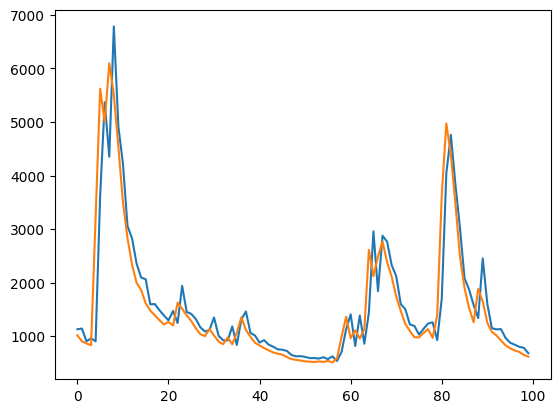

In [27]:
plot_predictions1(model2, X_test1, y_test1)

## GRU Model

In [28]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [30]:
model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp3])

Epoch 1/50
164/188 [=========================>....] - ETA: 0s - loss: 5359571.0000 - root_mean_squared_error: 2315.0747INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 2s 7ms/step - loss: 5432465.5000 - root_mean_squared_error: 2330.7649 - val_loss: 5425334.5000 - val_root_mean_squared_error: 2329.2349
Epoch 2/50
162/188 [========================>.....] - ETA: 0s - loss: 5340848.0000 - root_mean_squared_error: 2311.0276INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 7ms/step - loss: 5277141.0000 - root_mean_squared_error: 2297.2029 - val_loss: 5221449.5000 - val_root_mean_squared_error: 2285.0491
Epoch 3/50
181/188 [===========================>..] - ETA: 0s - loss: 4965958.5000 - root_mean_squared_error: 2228.4431INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 5009281.0000 - root_mean_squared_error: 2238.1423 - val_loss: 4929002.5000 - val_root_mean_squared_error: 2220.1357
Epoch 4/50
160/188 [========================>.....] - ETA: 0s - loss: 4669831.5000 - root_mean_squared_error: 2160.9792INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 4655104.5000 - root_mean_squared_error: 2157.5691 - val_loss: 4565347.0000 - val_root_mean_squared_error: 2136.6672
Epoch 5/50
176/188 [===========================>..] - ETA: 0s - loss: 4278427.5000 - root_mean_squared_error: 2068.4360INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 4262500.5000 - root_mean_squared_error: 2064.5825 - val_loss: 4203947.5000 - val_root_mean_squared_error: 2050.3530
Epoch 6/50
159/188 [========================>.....] - ETA: 0s - loss: 3887967.0000 - root_mean_squared_error: 1971.7928INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 3884029.5000 - root_mean_squared_error: 1970.7942 - val_loss: 3871523.0000 - val_root_mean_squared_error: 1967.6187
Epoch 7/50
171/188 [==========================>...] - ETA: 0s - loss: 3457459.2500 - root_mean_squared_error: 1859.4244INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 8ms/step - loss: 3544450.5000 - root_mean_squared_error: 1882.6711 - val_loss: 3591474.0000 - val_root_mean_squared_error: 1895.1184
Epoch 8/50
174/188 [==========================>...] - ETA: 0s - loss: 3255196.7500 - root_mean_squared_error: 1804.2164INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 7ms/step - loss: 3264590.7500 - root_mean_squared_error: 1806.8179 - val_loss: 3372163.7500 - val_root_mean_squared_error: 1836.3452
Epoch 9/50
173/188 [==========================>...] - ETA: 0s - loss: 3068963.2500 - root_mean_squared_error: 1751.8457INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 3068349.0000 - root_mean_squared_error: 1751.6703 - val_loss: 3241723.7500 - val_root_mean_squared_error: 1800.4788
Epoch 10/50
181/188 [===========================>..] - ETA: 0s - loss: 2949493.0000 - root_mean_squared_error: 1717.4088INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2927710.5000 - root_mean_squared_error: 1711.0554 - val_loss: 3139038.2500 - val_root_mean_squared_error: 1771.7332
Epoch 11/50
180/188 [===========================>..] - ETA: 0s - loss: 2867276.0000 - root_mean_squared_error: 1693.3032INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 7ms/step - loss: 2820994.5000 - root_mean_squared_error: 1679.5817 - val_loss: 3059886.2500 - val_root_mean_squared_error: 1749.2531
Epoch 12/50
174/188 [==========================>...] - ETA: 0s - loss: 2745822.2500 - root_mean_squared_error: 1657.0522INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2746164.0000 - root_mean_squared_error: 1657.1554 - val_loss: 3014494.2500 - val_root_mean_squared_error: 1736.2299
Epoch 13/50
172/188 [==========================>...] - ETA: 0s - loss: 2666626.5000 - root_mean_squared_error: 1632.9808INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2699947.7500 - root_mean_squared_error: 1643.1517 - val_loss: 2986611.5000 - val_root_mean_squared_error: 1728.1815
Epoch 14/50
173/188 [==========================>...] - ETA: 0s - loss: 2633170.2500 - root_mean_squared_error: 1622.7046INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2671587.7500 - root_mean_squared_error: 1634.4993 - val_loss: 2968064.0000 - val_root_mean_squared_error: 1722.8070
Epoch 15/50
177/188 [===========================>..] - ETA: 0s - loss: 2666308.2500 - root_mean_squared_error: 1632.8834INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 8ms/step - loss: 2652639.2500 - root_mean_squared_error: 1628.6925 - val_loss: 2953989.0000 - val_root_mean_squared_error: 1718.7173
Epoch 16/50
175/188 [==========================>...] - ETA: 0s - loss: 2596389.0000 - root_mean_squared_error: 1611.3314INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2636879.2500 - root_mean_squared_error: 1623.8470 - val_loss: 2940473.5000 - val_root_mean_squared_error: 1714.7809
Epoch 17/50
173/188 [==========================>...] - ETA: 0s - loss: 2623589.7500 - root_mean_squared_error: 1619.7499INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2624143.7500 - root_mean_squared_error: 1619.9209 - val_loss: 2927593.0000 - val_root_mean_squared_error: 1711.0210
Epoch 18/50
180/188 [===========================>..] - ETA: 0s - loss: 2593701.5000 - root_mean_squared_error: 1610.4973INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2612039.7500 - root_mean_squared_error: 1616.1807 - val_loss: 2916815.0000 - val_root_mean_squared_error: 1707.8685
Epoch 19/50
178/188 [===========================>..] - ETA: 0s - loss: 2613168.2500 - root_mean_squared_error: 1616.5297INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2602375.0000 - root_mean_squared_error: 1613.1879 - val_loss: 2902721.5000 - val_root_mean_squared_error: 1703.7375
Epoch 20/50
170/188 [==========================>...] - ETA: 0s - loss: 2568550.5000 - root_mean_squared_error: 1602.6698INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 8ms/step - loss: 2590474.0000 - root_mean_squared_error: 1609.4950 - val_loss: 2890239.7500 - val_root_mean_squared_error: 1700.0706
Epoch 21/50
183/188 [============================>.] - ETA: 0s - loss: 2588192.5000 - root_mean_squared_error: 1608.7860INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2579741.7500 - root_mean_squared_error: 1606.1575 - val_loss: 2878442.2500 - val_root_mean_squared_error: 1696.5973
Epoch 22/50
170/188 [==========================>...] - ETA: 0s - loss: 2522834.0000 - root_mean_squared_error: 1588.3431INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2571803.7500 - root_mean_squared_error: 1603.6844 - val_loss: 2869785.2500 - val_root_mean_squared_error: 1694.0441
Epoch 23/50
164/188 [=========================>....] - ETA: 0s - loss: 2577498.5000 - root_mean_squared_error: 1605.4590INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2560362.2500 - root_mean_squared_error: 1600.1132 - val_loss: 2855109.0000 - val_root_mean_squared_error: 1689.7068
Epoch 24/50
173/188 [==========================>...] - ETA: 0s - loss: 2540524.0000 - root_mean_squared_error: 1593.9021INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2550525.0000 - root_mean_squared_error: 1597.0364 - val_loss: 2844520.2500 - val_root_mean_squared_error: 1686.5706
Epoch 25/50
181/188 [===========================>..] - ETA: 0s - loss: 2539684.0000 - root_mean_squared_error: 1593.6385INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 8ms/step - loss: 2538402.2500 - root_mean_squared_error: 1593.2365 - val_loss: 2828169.7500 - val_root_mean_squared_error: 1681.7163
Epoch 26/50
176/188 [===========================>..] - ETA: 0s - loss: 2543614.2500 - root_mean_squared_error: 1594.8712INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2527777.5000 - root_mean_squared_error: 1589.8986 - val_loss: 2814861.7500 - val_root_mean_squared_error: 1677.7550
Epoch 27/50
178/188 [===========================>..] - ETA: 0s - loss: 2502914.2500 - root_mean_squared_error: 1582.0602INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2518668.0000 - root_mean_squared_error: 1587.0312 - val_loss: 2803586.0000 - val_root_mean_squared_error: 1674.3912
Epoch 28/50
183/188 [============================>.] - ETA: 0s - loss: 2505431.2500 - root_mean_squared_error: 1582.8555INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2506357.2500 - root_mean_squared_error: 1583.1479 - val_loss: 2791146.5000 - val_root_mean_squared_error: 1670.6725
Epoch 29/50
159/188 [========================>.....] - ETA: 0s - loss: 2526325.2500 - root_mean_squared_error: 1589.4418INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 8ms/step - loss: 2498022.7500 - root_mean_squared_error: 1580.5134 - val_loss: 2778196.5000 - val_root_mean_squared_error: 1666.7922
Epoch 30/50
159/188 [========================>.....] - ETA: 0s - loss: 2509997.2500 - root_mean_squared_error: 1584.2971INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2487046.5000 - root_mean_squared_error: 1577.0372 - val_loss: 2763976.0000 - val_root_mean_squared_error: 1662.5210
Epoch 31/50
179/188 [===========================>..] - ETA: 0s - loss: 2436519.5000 - root_mean_squared_error: 1560.9354INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2472139.2500 - root_mean_squared_error: 1572.3038 - val_loss: 2744286.7500 - val_root_mean_squared_error: 1656.5889
Epoch 32/50
176/188 [===========================>..] - ETA: 0s - loss: 2477308.2500 - root_mean_squared_error: 1573.9467INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2460477.0000 - root_mean_squared_error: 1568.5908 - val_loss: 2734360.0000 - val_root_mean_squared_error: 1653.5901
Epoch 33/50
170/188 [==========================>...] - ETA: 0s - loss: 2473147.2500 - root_mean_squared_error: 1572.6243INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 2s 8ms/step - loss: 2448717.0000 - root_mean_squared_error: 1564.8376 - val_loss: 2717089.0000 - val_root_mean_squared_error: 1648.3595
Epoch 34/50
183/188 [============================>.] - ETA: 0s - loss: 2439458.7500 - root_mean_squared_error: 1561.8767INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2437578.0000 - root_mean_squared_error: 1561.2745 - val_loss: 2707040.2500 - val_root_mean_squared_error: 1645.3086
Epoch 35/50
164/188 [=========================>....] - ETA: 0s - loss: 2420478.5000 - root_mean_squared_error: 1555.7887INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2424585.5000 - root_mean_squared_error: 1557.1080 - val_loss: 2688567.0000 - val_root_mean_squared_error: 1639.6851
Epoch 36/50
176/188 [===========================>..] - ETA: 0s - loss: 2387269.2500 - root_mean_squared_error: 1545.0791INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2411730.5000 - root_mean_squared_error: 1552.9747 - val_loss: 2673688.0000 - val_root_mean_squared_error: 1635.1416
Epoch 37/50
179/188 [===========================>..] - ETA: 0s - loss: 2413924.2500 - root_mean_squared_error: 1553.6809INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2401518.0000 - root_mean_squared_error: 1549.6832 - val_loss: 2661299.7500 - val_root_mean_squared_error: 1631.3490
Epoch 38/50
180/188 [===========================>..] - ETA: 0s - loss: 2385946.7500 - root_mean_squared_error: 1544.6510INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 8ms/step - loss: 2385976.7500 - root_mean_squared_error: 1544.6608 - val_loss: 2639396.7500 - val_root_mean_squared_error: 1624.6221
Epoch 39/50
181/188 [===========================>..] - ETA: 0s - loss: 2389875.0000 - root_mean_squared_error: 1545.9220INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2370079.2500 - root_mean_squared_error: 1539.5062 - val_loss: 2610590.0000 - val_root_mean_squared_error: 1615.7321
Epoch 40/50
176/188 [===========================>..] - ETA: 0s - loss: 2316546.0000 - root_mean_squared_error: 1522.0204INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2351681.5000 - root_mean_squared_error: 1533.5193 - val_loss: 2601736.5000 - val_root_mean_squared_error: 1612.9899
Epoch 41/50
166/188 [=========================>....] - ETA: 0s - loss: 2325011.7500 - root_mean_squared_error: 1524.7990INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2330065.5000 - root_mean_squared_error: 1526.4552 - val_loss: 2567403.2500 - val_root_mean_squared_error: 1602.3119
Epoch 42/50
176/188 [===========================>..] - ETA: 0s - loss: 2335263.5000 - root_mean_squared_error: 1528.1569INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 7ms/step - loss: 2308758.0000 - root_mean_squared_error: 1519.4597 - val_loss: 2536762.2500 - val_root_mean_squared_error: 1592.7217
Epoch 43/50
187/188 [============================>.] - ETA: 0s - loss: 2288495.0000 - root_mean_squared_error: 1512.7772INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2288603.2500 - root_mean_squared_error: 1512.8130 - val_loss: 2512199.0000 - val_root_mean_squared_error: 1584.9918
Epoch 44/50
180/188 [===========================>..] - ETA: 0s - loss: 2266300.0000 - root_mean_squared_error: 1505.4236INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2270532.0000 - root_mean_squared_error: 1506.8285 - val_loss: 2494241.0000 - val_root_mean_squared_error: 1579.3167
Epoch 45/50
164/188 [=========================>....] - ETA: 0s - loss: 2280598.5000 - root_mean_squared_error: 1510.1650INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2251014.7500 - root_mean_squared_error: 1500.3383 - val_loss: 2462957.0000 - val_root_mean_squared_error: 1569.3811
Epoch 46/50
183/188 [============================>.] - ETA: 0s - loss: 2217500.0000 - root_mean_squared_error: 1489.1273INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 8ms/step - loss: 2234243.5000 - root_mean_squared_error: 1494.7386 - val_loss: 2442321.7500 - val_root_mean_squared_error: 1562.7930
Epoch 47/50
173/188 [==========================>...] - ETA: 0s - loss: 2223795.0000 - root_mean_squared_error: 1491.2394INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2213749.5000 - root_mean_squared_error: 1487.8674 - val_loss: 2415706.0000 - val_root_mean_squared_error: 1554.2542
Epoch 48/50
179/188 [===========================>..] - ETA: 0s - loss: 2152300.5000 - root_mean_squared_error: 1467.0721INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2191739.0000 - root_mean_squared_error: 1480.4523 - val_loss: 2397100.7500 - val_root_mean_squared_error: 1548.2573
Epoch 49/50
186/188 [============================>.] - ETA: 0s - loss: 2181034.0000 - root_mean_squared_error: 1476.8324INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2173739.7500 - root_mean_squared_error: 1474.3608 - val_loss: 2370471.5000 - val_root_mean_squared_error: 1539.6335
Epoch 50/50
178/188 [===========================>..] - ETA: 0s - loss: 2149069.0000 - root_mean_squared_error: 1465.9703INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2156518.7500 - root_mean_squared_error: 1468.5090 - val_loss: 2346178.0000 - val_root_mean_squared_error: 1531.7239


33/33 [==============================] - 0s 693us/step


(      Predictions  Actuals
 0     1487.620361  1015.35
 1     1408.475098   905.19
 2     1403.660889   862.98
 3     1403.625732   832.00
 4     1403.625488  3217.89
 ...           ...      ...
 1025  2125.947510  5197.40
 1026  2125.947510  6368.46
 1027  2125.947510  7162.01
 1028  2125.947510  6869.41
 1029  2125.947510  6335.36
 
 [1030 rows x 2 columns],
 1575.0584163754088)

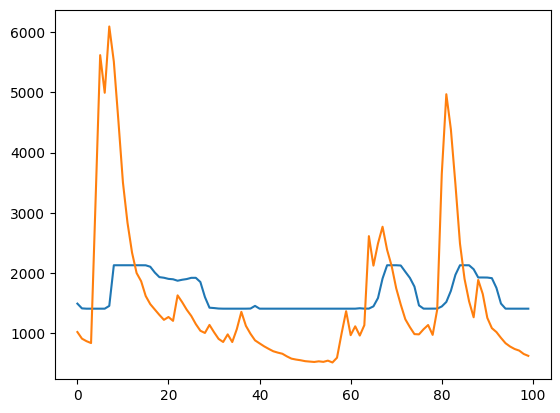

In [31]:
plot_predictions1(model3, X_test1, y_test1)

## Multi-variable

In [74]:
inflow_df = pd.DataFrame({'Inflow':inflow})
inflow_df['Seconds'] = inflow_df.index.map(pd.Timestamp.timestamp)
inflow_df

,Inflow,Seconds
time,,
2002-01-01,1829.75,1.009843e+09
2002-01-02,7279.46,1.009930e+09
2002-01-03,5261.85,1.010016e+09
2002-01-04,2951.97,1.010102e+09
2002-01-05,1868.53,1.010189e+09
...,...,...
2023-12-27,5197.40,1.703635e+09
2023-12-28,6368.46,1.703722e+09
2023-12-29,7162.01,1.703808e+09


In [75]:
day = 24*60*60
year = (365.2425)*day

inflow_df['Rain'] = df['precip_total_daily']
inflow_df['Temp'] = df['temp_mean_daily']
inflow_df['Year sin'] = np.sin(inflow_df['Seconds'] * (2 * np.pi / year))
inflow_df['Year cos'] = np.cos(inflow_df['Seconds'] * (2 * np.pi / year))
inflow_df = inflow_df.drop('Seconds', axis=1)
inflow_df

,Inflow,Rain,Temp,Year sin,Year cos
time,,,,,
2002-01-01,1829.75,2.2,1.250000,0.004129,0.999991
2002-01-02,7279.46,0.0,-0.837500,0.021330,0.999772
2002-01-03,5261.85,0.0,-5.166667,0.038525,0.999258
2002-01-04,2951.97,0.0,-6.025000,0.055708,0.998447
2002-01-05,1868.53,0.1,-3.466667,0.072875,0.997341
...,...,...,...,...,...
2023-12-27,5197.40,0.0,0.471667,-0.087536,0.996161
2023-12-28,6368.46,0.0,0.255556,-0.070387,0.997520
2023-12-29,7162.01,0.0,0.039444,-0.053217,0.998583


In [80]:
def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

import numpy as np

def df_to_X_y2_forecast(df, window_size=6):
    """
    Prepares data for forecasting using both historical data and external variables.
    
    Parameters:
        df          : pandas DataFrame with columns in the following order:
                      [Inflow, Rain, Temp, cos_year, sin_year, ...]
        window_size : number of past days to use as historical input.
    
    Returns:
        X     : numpy array of shape (num_samples, window_size, num_features) containing historical data.
        X_exo : numpy array of shape (num_samples, 4) containing external variables (rain, temp, cos_year, sin_year)
                for the forecast day.
        y     : numpy array of shape (num_samples,) with the target inflow value for the forecast day.
    """
    df_as_np = df.to_numpy()
    X, X_exo, y = [], [], []
    for i in range(len(df_as_np) - window_size):
        # Historical window: all features for the past 'window_size' days.
        hist_window = df_as_np[i:i+window_size]
        X.append(hist_window)
        # Forecast day: use external variables from columns 1:5
        external_vars = df_as_np[i + window_size, 1:5]
        X_exo.append(external_vars)
        # Target: inflow for the forecast day (assumed in column 0)
        label = df_as_np[i + window_size, 0]
        y.append(label)
    
    return np.array(X), np.array(X_exo), np.array(y)

import numpy as np

def df_to_X_y_with_exo_in_sequence(df, window_size=6):
    """
    Prepares data for forecasting by incorporating forecast-day exogenous variables
    (Rain, Temp, cos_year, sin_year) into the input sequence.

    Parameters:
      df          : DataFrame with columns in order:
                    [Inflow, Rain, Temp, cos_year, sin_year]
      window_size : Number of past days to use (e.g., 6)

    Returns:
      X : Array of shape (num_samples, window_size, 9) where the first 5 columns
          of every timestep come from the historical data. For the last timestep, columns
          5 to 8 hold the forecast-day's exogenous features.
      y : Array of target inflow values for the forecast day.
    """
    df_as_np = df.to_numpy()
    X, y = [], []
    # We need enough data to fill window_size days, then one day for the forecast
    for i in range(len(df_as_np) - window_size):
        # Get historical data for window_size days: shape (window_size, 5)
        hist = df_as_np[i:i+window_size]
        
        # Get forecast-day exogenous features from columns 1:5 (Rain, Temp, cos_year, sin_year)
        exo = df_as_np[i+window_size, 1:5]
        
        # Create an empty array for our new input with additional 4 features: shape (window_size, 9)
        sample = np.zeros((window_size, 5 + 4))
        
        # Fill all timesteps with the historical 5 features
        sample[:, :5] = hist
        
        # For the last timestep only, append the forecast-day exogenous features in the new columns
        sample[-1, 5:] = exo
        
        # The target is the inflow for the forecast day (assumed at column 0)
        label = df_as_np[i+window_size, 0]
        
        X.append(sample)
        y.append(label)
    
    return np.array(X), np.array(y)



In [81]:
# X2, y2 = df_to_X_y2(inflow_df)
X2, y2 = df_to_X_y_with_exo_in_sequence(inflow_df)
X3, X3_exo, y3 = df_to_X_y2_forecast(inflow_df)
X2.shape, y2.shape , X3.shape, X3_exo.shape, y3.shape

((8029, 6, 9), (8029,), (8029, 6, 5), (8029, 4), (8029,))

In [73]:
X3_exo[-1]

array([ 0.        , -0.39277778, -0.01883593,  0.99982259])

In [82]:
X2_train, y2_train = X2[:6000], y2[:6000]
X2_val, y2_val = X2[6000:7000], y2[6000:7000]
X2_test, y2_test = X2[7000:], y2[7000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((6000, 6, 9), (6000,), (1000, 6, 9), (1000,), (1029, 6, 9), (1029,))

In [78]:
# Suppose X2 is your historical window data (shape: (num_samples, window_size, num_features))
#        X3_exo is your exogenous data for the forecast day (shape: (num_samples, num_exo_features))
#        y2 is your target (shape: (num_samples,))

# Example: 0..5999 for training, 6000..6999 for validation, 7000..end for test
train_end = 6000
val_end   = 7000

X3_train, X3_exo_train, y3_train = X3[:train_end],      X3_exo[:train_end],      y3[:train_end]
X3_val,   X3_exo_val,   y3_val   = X3[train_end:val_end], X3_exo[train_end:val_end], y3[train_end:val_end]
X3_test,  X3_exo_test,  y3_test  = X3[val_end:],        X3_exo[val_end:],        y3[val_end:]

# Print shapes to confirm
print("X3_train shape:", X3_train.shape, 
      "X3_exo_train shape:", X3_exo_train.shape, 
      "y3_train shape:", y3_train.shape)

print("X3_val shape:", X3_val.shape, 
      "X3_exo_val shape:", X3_exo_val.shape, 
      "y3_val shape:", y3_val.shape)

print("X3_test shape:", X3_test.shape, 
      "X3_exo_test shape:", X3_exo_test.shape, 
      "y3_test shape:", y3_test.shape)


X3_train shape: (6000, 6, 5) X3_exo_train shape: (6000, 4) y3_train shape: (6000,)
X3_val shape: (1000, 6, 5) X3_exo_val shape: (1000, 4) y3_val shape: (1000,)
X3_test shape: (1029, 6, 5) X3_exo_test shape: (1029, 4) y3_test shape: (1029,)


### Preprocessing

In [79]:
inflow_training_mean = np.mean(X3_train[:, :, 0])
inflow_training_std  = np.std(X3_train[:, :, 0])

rain_training_mean = np.mean(X3_train[:, :, 1])
rain_training_std  = np.std(X3_train[:, :, 1])

temp_training_mean = np.mean(X3_train[:, :, 2])
temp_training_std  = np.std(X3_train[:, :, 2])

rain_exo_training_mean    = np.mean(X3_exo_train[:, 0])
rain_exo_training_std     = np.std(X3_exo_train[:, 0])

temp_exo_training_mean    = np.mean(X3_exo_train[:, 1])
temp_exo_training_std     = np.std(X3_exo_train[:, 1])

def preprocess_X3(X):
    """Standardize the first three channels (inflow, rain, temp) in the historical window."""
    X[:, :, 0] = (X[:, :, 0] - inflow_training_mean) / inflow_training_std
    X[:, :, 1] = (X[:, :, 1] - rain_training_mean)   / rain_training_std
    X[:, :, 2] = (X[:, :, 2] - temp_training_mean)   / temp_training_std
    return X

def preprocess_X3_exo(X_exo):
    """
    Standardize the exogenous features [Rain, Temp, cos_year, sin_year].
    """
    X_exo[:, 0] = (X_exo[:, 0] - rain_exo_training_mean)    / rain_exo_training_std
    X_exo[:, 1] = (X_exo[:, 1] - temp_exo_training_mean)    / temp_exo_training_std
    return X_exo

def preprocess_output3(y):
    """Standardize the inflow target based on inflow_training_mean/std."""
    y[:] = (y[:] - inflow_training_mean) / inflow_training_std
    return y

preprocess_X3(X3_train)
preprocess_X3(X3_val)
preprocess_X3(X3_test)

preprocess_X3_exo(X3_exo_train)
preprocess_X3_exo(X3_exo_val)
preprocess_X3_exo(X3_exo_test)

preprocess_output3(y3_train)
preprocess_output3(y3_val)
preprocess_output3(y3_test)

array([-0.44978334, -0.47520904, -0.49387022, ...,  3.31908774,
        3.14283659,  2.82114513])

In [83]:
# Compute the training statistics from the first channel (inflow) in X2_train
inflow_training_mean = np.mean(X2_train[:, :, 0])
inflow_training_std = np.std(X2_train[:, :, 0])

rain_training_mean = np.mean(X2_train[:, :, 1])
rain_training_std = np.std(X2_train[:, :, 1])

temp_training_mean = np.mean(X2_train[:, :, 2])
temp_training_std = np.std(X2_train[:, :, 2])

# Define the preprocessing functions for features and output
def preprocess(X):
    # Standardize the first three channels (features)
    X[:, :, 0] = (X[:, :, 0] - inflow_training_mean) / inflow_training_std 
    X[:, :, 1] = (X[:, :, 1] - rain_training_mean) / rain_training_std
    X[:, :, 2] = (X[:, :, 2] - temp_training_mean) / temp_training_std 
    return X

def preprocess_output(y):
    # Standardize every element in y
    y[:] = (y[:] - inflow_training_mean) / inflow_training_std
    return y

# Apply preprocessing to all datasets
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)
preprocess_output(y2_train)
preprocess_output(y2_val)
preprocess_output(y2_test)

array([-0.44978334, -0.47520904, -0.49387022, ...,  3.31908774,
        3.14283659,  2.82114513])

In [84]:
X2_test[0] , y2_test[0]

(array([[-0.16163742, -0.47390815, -1.02955591,  0.86394287,  0.50358984,
          0.        ,  0.        ,  0.        ,  0.        ],
        [-0.20441717, -0.47390815, -1.23345294,  0.87247775,  0.48865384,
          0.        ,  0.        ,  0.        ,  0.        ],
        [-0.23613153, -0.47390815, -1.06244253,  0.88075444,  0.47357324,
          0.        ,  0.        ,  0.        ,  0.        ],
        [-0.34333391, -0.47390815, -1.57218509,  0.8887705 ,  0.45835249,
          0.        ,  0.        ,  0.        ,  0.        ],
        [-0.3822465 , -0.44894945, -1.00719301,  0.89652354,  0.4429961 ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [-0.38342713, -0.47390815, -1.00521982,  0.90401127,  0.42750862,
          0.        , -3.29166667,  0.91123148,  0.41189463]]),
 -0.44978333905391354)

In [90]:
import numpy as np
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model

# 1) Define two inputs: historical window and day-of exogenous
hist_input = Input(shape=(6, 5), name="historical_input")
exo_input  = Input(shape=(4,), name="exo_input")

# 2) Process historical data with LSTM
x = LSTM(64)(hist_input)

# 3) Process exogenous data with a small Dense
exo = Dense(8, activation='relu')(exo_input)

# 4) Concatenate both representations
combined = Concatenate()([x, exo])

# 5) Final layers
dense1 = Dense(8, activation='relu')(combined)
output = Dense(1, activation='linear')(dense1)

# 6) Build the model
model4_exo = Model(inputs=[hist_input, exo_input], outputs=output)
model4_exo.compile(optimizer='adam', loss='mse')

model4_exo.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 historical_input (InputLay  [(None, 6, 5)]               0         []                            
 er)                                                                                              
                                                                                                  
 exo_input (InputLayer)      [(None, 4)]                  0         []                            
                                                                                                  
 lstm_6 (LSTM)               (None, 64)                   17920     ['historical_input[0][0]']    
                                                                                                  
 dense_16 (Dense)            (None, 8)                    40        ['exo_input[0][0]']     

In [91]:
cp4_exo = ModelCheckpoint('model4_exo/', save_best_only=True)
model4_exo.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [92]:
model4_exo.fit(x = [X3_train, X3_exo_train], y = y3_train, validation_data=([X3_val, X3_exo_val], y3_val), epochs=100, callbacks=[cp4_exo])

Epoch 1/100
186/188 [============================>.] - ETA: 0s - loss: 0.7279 - root_mean_squared_error: 0.8531INFO:tensorflow:Assets written to: model4_exo/assets


INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 3s 9ms/step - loss: 0.7264 - root_mean_squared_error: 0.8523 - val_loss: 0.4041 - val_root_mean_squared_error: 0.6357
Epoch 2/100
179/188 [===========================>..] - ETA: 0s - loss: 0.3364 - root_mean_squared_error: 0.5800INFO:tensorflow:Assets written to: model4_exo/assets


INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 1s 8ms/step - loss: 0.3373 - root_mean_squared_error: 0.5807 - val_loss: 0.2132 - val_root_mean_squared_error: 0.4618
Epoch 3/100
176/188 [===========================>..] - ETA: 0s - loss: 0.2608 - root_mean_squared_error: 0.5107INFO:tensorflow:Assets written to: model4_exo/assets


INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 1s 8ms/step - loss: 0.2578 - root_mean_squared_error: 0.5077 - val_loss: 0.1465 - val_root_mean_squared_error: 0.3828
Epoch 4/100
175/188 [==========================>...] - ETA: 0s - loss: 0.2094 - root_mean_squared_error: 0.4576INFO:tensorflow:Assets written to: model4_exo/assets


INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 1s 8ms/step - loss: 0.2075 - root_mean_squared_error: 0.4555 - val_loss: 0.1022 - val_root_mean_squared_error: 0.3197
Epoch 5/100
179/188 [===========================>..] - ETA: 0s - loss: 0.1654 - root_mean_squared_error: 0.4067INFO:tensorflow:Assets written to: model4_exo/assets


INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 2s 10ms/step - loss: 0.1686 - root_mean_squared_error: 0.4106 - val_loss: 0.0761 - val_root_mean_squared_error: 0.2759
Epoch 6/100
181/188 [===========================>..] - ETA: 0s - loss: 0.1407 - root_mean_squared_error: 0.3752INFO:tensorflow:Assets written to: model4_exo/assets


INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 1s 8ms/step - loss: 0.1398 - root_mean_squared_error: 0.3739 - val_loss: 0.0533 - val_root_mean_squared_error: 0.2309
Epoch 7/100
170/188 [==========================>...] - ETA: 0s - loss: 0.1188 - root_mean_squared_error: 0.3446INFO:tensorflow:Assets written to: model4_exo/assets


INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 1s 8ms/step - loss: 0.1181 - root_mean_squared_error: 0.3436 - val_loss: 0.0450 - val_root_mean_squared_error: 0.2121
Epoch 8/100
186/188 [============================>.] - ETA: 0s - loss: 0.1041 - root_mean_squared_error: 0.3226INFO:tensorflow:Assets written to: model4_exo/assets


INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 1s 8ms/step - loss: 0.1037 - root_mean_squared_error: 0.3221 - val_loss: 0.0390 - val_root_mean_squared_error: 0.1975
Epoch 9/100
170/188 [==========================>...] - ETA: 0s - loss: 0.0963 - root_mean_squared_error: 0.3102INFO:tensorflow:Assets written to: model4_exo/assets


INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 1s 8ms/step - loss: 0.0946 - root_mean_squared_error: 0.3075 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1946
Epoch 10/100
178/188 [===========================>..] - ETA: 0s - loss: 0.0902 - root_mean_squared_error: 0.3004INFO:tensorflow:Assets written to: model4_exo/assets


INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 2s 10ms/step - loss: 0.0887 - root_mean_squared_error: 0.2977 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1944
Epoch 11/100
160/188 [========================>.....] - ETA: 0s - loss: 0.0823 - root_mean_squared_error: 0.2869INFO:tensorflow:Assets written to: model4_exo/assets


INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 1s 8ms/step - loss: 0.0843 - root_mean_squared_error: 0.2903 - val_loss: 0.0372 - val_root_mean_squared_error: 0.1930
Epoch 12/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0809 - root_mean_squared_error: 0.2845 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1952
Epoch 13/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0781 - root_mean_squared_error: 0.2795 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1953
Epoch 14/100
173/188 [==========================>...] - ETA: 0s - loss: 0.0772 - root_mean_squared_error: 0.2778INFO:tensorflow:Assets written to: model4_exo/assets


INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 1s 8ms/step - loss: 0.0757 - root_mean_squared_error: 0.2751 - val_loss: 0.0368 - val_root_mean_squared_error: 0.1918
Epoch 15/100
187/188 [============================>.] - ETA: 0s - loss: 0.0736 - root_mean_squared_error: 0.2714INFO:tensorflow:Assets written to: model4_exo/assets


INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 2s 8ms/step - loss: 0.0735 - root_mean_squared_error: 0.2710 - val_loss: 0.0361 - val_root_mean_squared_error: 0.1901
Epoch 16/100
188/188 [==============================] - ETA: 0s - loss: 0.0716 - root_mean_squared_error: 0.2676INFO:tensorflow:Assets written to: model4_exo/assets


INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 2s 9ms/step - loss: 0.0716 - root_mean_squared_error: 0.2676 - val_loss: 0.0345 - val_root_mean_squared_error: 0.1857
Epoch 17/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0703 - root_mean_squared_error: 0.2652 - val_loss: 0.0365 - val_root_mean_squared_error: 0.1911
Epoch 18/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0687 - root_mean_squared_error: 0.2621 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1906
Epoch 19/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0673 - root_mean_squared_error: 0.2593 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1904
Epoch 20/100
188/188 [==============================] - 0s 3ms/step - loss: 0.0665 - root_mean_squared_error: 0.2578 - val_loss: 0.0351 - val_root_mean_squared_error: 0.1873
Epoch 21/100
176/188 [===========================>..] - ETA: 0s - loss: 0.0649 - root_mean_squared_error: 0.2547INFO:tensorflow:Assets written 

INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 2s 11ms/step - loss: 0.0654 - root_mean_squared_error: 0.2558 - val_loss: 0.0339 - val_root_mean_squared_error: 0.1840
Epoch 22/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0648 - root_mean_squared_error: 0.2546 - val_loss: 0.0339 - val_root_mean_squared_error: 0.1842
Epoch 23/100
187/188 [============================>.] - ETA: 0s - loss: 0.0636 - root_mean_squared_error: 0.2522INFO:tensorflow:Assets written to: model4_exo/assets


INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 1s 7ms/step - loss: 0.0635 - root_mean_squared_error: 0.2520 - val_loss: 0.0335 - val_root_mean_squared_error: 0.1831
Epoch 24/100
181/188 [===========================>..] - ETA: 0s - loss: 0.0624 - root_mean_squared_error: 0.2497INFO:tensorflow:Assets written to: model4_exo/assets


INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 1s 8ms/step - loss: 0.0627 - root_mean_squared_error: 0.2504 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1804
Epoch 25/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0616 - root_mean_squared_error: 0.2482 - val_loss: 0.0339 - val_root_mean_squared_error: 0.1840
Epoch 26/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0613 - root_mean_squared_error: 0.2475 - val_loss: 0.0329 - val_root_mean_squared_error: 0.1815
Epoch 27/100
165/188 [=========================>....] - ETA: 0s - loss: 0.0582 - root_mean_squared_error: 0.2413INFO:tensorflow:Assets written to: model4_exo/assets


INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 2s 8ms/step - loss: 0.0605 - root_mean_squared_error: 0.2459 - val_loss: 0.0319 - val_root_mean_squared_error: 0.1787
Epoch 28/100
188/188 [==============================] - 0s 3ms/step - loss: 0.0599 - root_mean_squared_error: 0.2446 - val_loss: 0.0355 - val_root_mean_squared_error: 0.1884
Epoch 29/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0596 - root_mean_squared_error: 0.2440 - val_loss: 0.0328 - val_root_mean_squared_error: 0.1811
Epoch 30/100
169/188 [=========================>....] - ETA: 0s - loss: 0.0594 - root_mean_squared_error: 0.2438INFO:tensorflow:Assets written to: model4_exo/assets


INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 1s 8ms/step - loss: 0.0589 - root_mean_squared_error: 0.2426 - val_loss: 0.0317 - val_root_mean_squared_error: 0.1781
Epoch 31/100
178/188 [===========================>..] - ETA: 0s - loss: 0.0592 - root_mean_squared_error: 0.2434INFO:tensorflow:Assets written to: model4_exo/assets


INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 2s 10ms/step - loss: 0.0584 - root_mean_squared_error: 0.2416 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1742
Epoch 32/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0581 - root_mean_squared_error: 0.2410 - val_loss: 0.0320 - val_root_mean_squared_error: 0.1787
Epoch 33/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0575 - root_mean_squared_error: 0.2399 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1749
Epoch 34/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0574 - root_mean_squared_error: 0.2395 - val_loss: 0.0307 - val_root_mean_squared_error: 0.1752
Epoch 35/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0570 - root_mean_squared_error: 0.2388 - val_loss: 0.0332 - val_root_mean_squared_error: 0.1821
Epoch 36/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0565 - root_mean_squared_error: 0.2377 - val_loss: 0.0308 - val_

INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 1s 7ms/step - loss: 0.0559 - root_mean_squared_error: 0.2363 - val_loss: 0.0282 - val_root_mean_squared_error: 0.1678
Epoch 38/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0556 - root_mean_squared_error: 0.2357 - val_loss: 0.0352 - val_root_mean_squared_error: 0.1877
Epoch 39/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0554 - root_mean_squared_error: 0.2353 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1708
Epoch 40/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0552 - root_mean_squared_error: 0.2350 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1709
Epoch 41/100
180/188 [===========================>..] - ETA: 0s - loss: 0.0553 - root_mean_squared_error: 0.2352INFO:tensorflow:Assets written to: model4_exo/assets


INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 1s 7ms/step - loss: 0.0549 - root_mean_squared_error: 0.2344 - val_loss: 0.0276 - val_root_mean_squared_error: 0.1661
Epoch 42/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0546 - root_mean_squared_error: 0.2337 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1708
Epoch 43/100
178/188 [===========================>..] - ETA: 0s - loss: 0.0538 - root_mean_squared_error: 0.2320INFO:tensorflow:Assets written to: model4_exo/assets


INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 1s 7ms/step - loss: 0.0541 - root_mean_squared_error: 0.2325 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1653
Epoch 44/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0542 - root_mean_squared_error: 0.2329 - val_loss: 0.0288 - val_root_mean_squared_error: 0.1696
Epoch 45/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0541 - root_mean_squared_error: 0.2325 - val_loss: 0.0302 - val_root_mean_squared_error: 0.1738
Epoch 46/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0533 - root_mean_squared_error: 0.2308 - val_loss: 0.0302 - val_root_mean_squared_error: 0.1737
Epoch 47/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0534 - root_mean_squared_error: 0.2310 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1710
Epoch 48/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0529 - root_mean_squared_error: 0.2301 - val_loss: 0.0283 - val_r

INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 1s 8ms/step - loss: 0.0508 - root_mean_squared_error: 0.2254 - val_loss: 0.0263 - val_root_mean_squared_error: 0.1623
Epoch 59/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0508 - root_mean_squared_error: 0.2255 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1707
Epoch 60/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0504 - root_mean_squared_error: 0.2244 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1751
Epoch 61/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0504 - root_mean_squared_error: 0.2246 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1742
Epoch 62/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0504 - root_mean_squared_error: 0.2244 - val_loss: 0.0282 - val_root_mean_squared_error: 0.1680
Epoch 63/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0507 - root_mean_squared_error: 0.2252 - val_loss: 0.0277 - val_r

INFO:tensorflow:Assets written to: model4_exo/assets


188/188 [==============================] - 2s 11ms/step - loss: 0.0473 - root_mean_squared_error: 0.2174 - val_loss: 0.0261 - val_root_mean_squared_error: 0.1616
Epoch 85/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0473 - root_mean_squared_error: 0.2175 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1710
Epoch 86/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0473 - root_mean_squared_error: 0.2174 - val_loss: 0.0288 - val_root_mean_squared_error: 0.1697
Epoch 87/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0470 - root_mean_squared_error: 0.2167 - val_loss: 0.0307 - val_root_mean_squared_error: 0.1753
Epoch 88/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0468 - root_mean_squared_error: 0.2164 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1705
Epoch 89/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0467 - root_mean_squared_error: 0.2161 - val_loss: 0.0290 - val_

In [93]:
rmse(model4_exo.predict([X3_test, X3_exo_test]), y3_test)

33/33 [==============================] - 0s 1ms/step


0.21253882725698503

In [85]:
model4 = Sequential()
model4.add(InputLayer((6, 9)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                18944     
                                                                 
 dense_14 (Dense)            (None, 8)                 520       
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 19473 (76.07 KB)
Trainable params: 19473 (76.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [86]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [87]:
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=100, callbacks=[cp4])

Epoch 1/100
172/188 [==========================>...] - ETA: 0s - loss: 0.8551 - root_mean_squared_error: 0.9247INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 3s 9ms/step - loss: 0.8357 - root_mean_squared_error: 0.9141 - val_loss: 0.4917 - val_root_mean_squared_error: 0.7012
Epoch 2/100
177/188 [===========================>..] - ETA: 0s - loss: 0.3613 - root_mean_squared_error: 0.6011INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 8ms/step - loss: 0.3537 - root_mean_squared_error: 0.5947 - val_loss: 0.2006 - val_root_mean_squared_error: 0.4479
Epoch 3/100
180/188 [===========================>..] - ETA: 0s - loss: 0.2479 - root_mean_squared_error: 0.4979INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 0.2494 - root_mean_squared_error: 0.4994 - val_loss: 0.1325 - val_root_mean_squared_error: 0.3640
Epoch 4/100
179/188 [===========================>..] - ETA: 0s - loss: 0.2033 - root_mean_squared_error: 0.4509INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 2s 10ms/step - loss: 0.1994 - root_mean_squared_error: 0.4466 - val_loss: 0.0942 - val_root_mean_squared_error: 0.3069
Epoch 5/100
185/188 [============================>.] - ETA: 0s - loss: 0.1615 - root_mean_squared_error: 0.4019INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 0.1605 - root_mean_squared_error: 0.4006 - val_loss: 0.0631 - val_root_mean_squared_error: 0.2512
Epoch 6/100
183/188 [============================>.] - ETA: 0s - loss: 0.1326 - root_mean_squared_error: 0.3642INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 0.1319 - root_mean_squared_error: 0.3631 - val_loss: 0.0475 - val_root_mean_squared_error: 0.2180
Epoch 7/100
166/188 [=========================>....] - ETA: 0s - loss: 0.1157 - root_mean_squared_error: 0.3401INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 8ms/step - loss: 0.1120 - root_mean_squared_error: 0.3347 - val_loss: 0.0403 - val_root_mean_squared_error: 0.2009
Epoch 8/100
171/188 [==========================>...] - ETA: 0s - loss: 0.1013 - root_mean_squared_error: 0.3182INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 8ms/step - loss: 0.1000 - root_mean_squared_error: 0.3162 - val_loss: 0.0401 - val_root_mean_squared_error: 0.2001
Epoch 9/100
177/188 [===========================>..] - ETA: 0s - loss: 0.0921 - root_mean_squared_error: 0.3035INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 2s 10ms/step - loss: 0.0919 - root_mean_squared_error: 0.3031 - val_loss: 0.0393 - val_root_mean_squared_error: 0.1984
Epoch 10/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0866 - root_mean_squared_error: 0.2943 - val_loss: 0.0404 - val_root_mean_squared_error: 0.2009
Epoch 11/100
183/188 [============================>.] - ETA: 0s - loss: 0.0828 - root_mean_squared_error: 0.2877INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 0.0825 - root_mean_squared_error: 0.2872 - val_loss: 0.0361 - val_root_mean_squared_error: 0.1900
Epoch 12/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0794 - root_mean_squared_error: 0.2819 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1945
Epoch 13/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0765 - root_mean_squared_error: 0.2765 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1963
Epoch 14/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0740 - root_mean_squared_error: 0.2720 - val_loss: 0.0400 - val_root_mean_squared_error: 0.2001
Epoch 15/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0719 - root_mean_squared_error: 0.2682 - val_loss: 0.0375 - val_root_mean_squared_error: 0.1937
Epoch 16/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0698 - root_mean_squared_error: 0.2642 - val_loss: 0.0375 - val_r

INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 0.0617 - root_mean_squared_error: 0.2484 - val_loss: 0.0347 - val_root_mean_squared_error: 0.1864
Epoch 23/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0609 - root_mean_squared_error: 0.2467 - val_loss: 0.0355 - val_root_mean_squared_error: 0.1884
Epoch 24/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0599 - root_mean_squared_error: 0.2448 - val_loss: 0.0393 - val_root_mean_squared_error: 0.1982
Epoch 25/100
161/188 [========================>.....] - ETA: 0s - loss: 0.0582 - root_mean_squared_error: 0.2412INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 0.0592 - root_mean_squared_error: 0.2432 - val_loss: 0.0345 - val_root_mean_squared_error: 0.1859
Epoch 26/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0583 - root_mean_squared_error: 0.2415 - val_loss: 0.0357 - val_root_mean_squared_error: 0.1889
Epoch 27/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0576 - root_mean_squared_error: 0.2400 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1904
Epoch 28/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0571 - root_mean_squared_error: 0.2389 - val_loss: 0.0354 - val_root_mean_squared_error: 0.1883
Epoch 29/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0564 - root_mean_squared_error: 0.2374 - val_loss: 0.0352 - val_root_mean_squared_error: 0.1876
Epoch 30/100
174/188 [==========================>...] - ETA: 0s - loss: 0.0556 - root_mean_squared_error: 0.2359INFO:tensorflow:Assets written 

INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 0.0560 - root_mean_squared_error: 0.2367 - val_loss: 0.0337 - val_root_mean_squared_error: 0.1837
Epoch 31/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0552 - root_mean_squared_error: 0.2350 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1845
Epoch 32/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0549 - root_mean_squared_error: 0.2343 - val_loss: 0.0352 - val_root_mean_squared_error: 0.1877
Epoch 33/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0544 - root_mean_squared_error: 0.2333 - val_loss: 0.0351 - val_root_mean_squared_error: 0.1873
Epoch 34/100
164/188 [=========================>....] - ETA: 0s - loss: 0.0561 - root_mean_squared_error: 0.2368INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 0.0541 - root_mean_squared_error: 0.2327 - val_loss: 0.0327 - val_root_mean_squared_error: 0.1807
Epoch 35/100
182/188 [============================>.] - ETA: 0s - loss: 0.0543 - root_mean_squared_error: 0.2330INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 2s 10ms/step - loss: 0.0534 - root_mean_squared_error: 0.2311 - val_loss: 0.0320 - val_root_mean_squared_error: 0.1787
Epoch 36/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0533 - root_mean_squared_error: 0.2309 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1843
Epoch 37/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0527 - root_mean_squared_error: 0.2296 - val_loss: 0.0339 - val_root_mean_squared_error: 0.1842
Epoch 38/100
172/188 [==========================>...] - ETA: 0s - loss: 0.0544 - root_mean_squared_error: 0.2332INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 0.0527 - root_mean_squared_error: 0.2295 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1749
Epoch 39/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0522 - root_mean_squared_error: 0.2285 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1807
Epoch 40/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0516 - root_mean_squared_error: 0.2271 - val_loss: 0.0328 - val_root_mean_squared_error: 0.1812
Epoch 41/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0513 - root_mean_squared_error: 0.2266 - val_loss: 0.0323 - val_root_mean_squared_error: 0.1799
Epoch 42/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0513 - root_mean_squared_error: 0.2264 - val_loss: 0.0341 - val_root_mean_squared_error: 0.1847
Epoch 43/100
176/188 [===========================>..] - ETA: 0s - loss: 0.0508 - root_mean_squared_error: 0.2253INFO:tensorflow:Assets written 

INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 0.0510 - root_mean_squared_error: 0.2258 - val_loss: 0.0300 - val_root_mean_squared_error: 0.1731
Epoch 44/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0505 - root_mean_squared_error: 0.2247 - val_loss: 0.0315 - val_root_mean_squared_error: 0.1776
Epoch 45/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0502 - root_mean_squared_error: 0.2240 - val_loss: 0.0307 - val_root_mean_squared_error: 0.1753
Epoch 46/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0503 - root_mean_squared_error: 0.2242 - val_loss: 0.0323 - val_root_mean_squared_error: 0.1796
Epoch 47/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0498 - root_mean_squared_error: 0.2233 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1790
Epoch 48/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0497 - root_mean_squared_error: 0.2229 - val_loss: 0.0314 - val_r

INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 0.0470 - root_mean_squared_error: 0.2167 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1709
Epoch 63/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0467 - root_mean_squared_error: 0.2161 - val_loss: 0.0332 - val_root_mean_squared_error: 0.1823
Epoch 64/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0467 - root_mean_squared_error: 0.2160 - val_loss: 0.0327 - val_root_mean_squared_error: 0.1807
Epoch 65/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0466 - root_mean_squared_error: 0.2159 - val_loss: 0.0293 - val_root_mean_squared_error: 0.1710
Epoch 66/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0464 - root_mean_squared_error: 0.2154 - val_loss: 0.0355 - val_root_mean_squared_error: 0.1885
Epoch 67/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0461 - root_mean_squared_error: 0.2148 - val_loss: 0.0320 - val_r

INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 0.0457 - root_mean_squared_error: 0.2138 - val_loss: 0.0287 - val_root_mean_squared_error: 0.1694
Epoch 73/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0454 - root_mean_squared_error: 0.2130 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1707
Epoch 74/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0453 - root_mean_squared_error: 0.2128 - val_loss: 0.0332 - val_root_mean_squared_error: 0.1822
Epoch 75/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0451 - root_mean_squared_error: 0.2123 - val_loss: 0.0309 - val_root_mean_squared_error: 0.1757
Epoch 76/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0452 - root_mean_squared_error: 0.2126 - val_loss: 0.0338 - val_root_mean_squared_error: 0.1838
Epoch 77/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0449 - root_mean_squared_error: 0.2119 - val_loss: 0.0310 - val_r

In [94]:
def postprocess(arr):
  arr = (arr*inflow_training_std) + inflow_training_mean
  return arr

def get_predictions_postprocessed(model, X, y):
  predictions = model.predict(X)
  inflow_preds = postprocess(predictions[:, 0])
  inflow_actuals = postprocess(y[:])
  df = pd.DataFrame(data={'Inflow Predictions': inflow_preds, 
                          'Inflow Actuals':inflow_actuals})
  return df

post_processed_df = get_predictions_postprocessed(model4_exo, [X3_test,X3_exo_test], y3_test)
post_processed_df

33/33 [==============================] - 0s 904us/step


,Inflow Predictions,Inflow Actuals
0,976.597046,905.19
1,936.422974,862.98
2,865.569824,832.00
3,2337.095215,3217.89
4,6866.703613,5620.73
...,...,...
1024,4527.601074,5197.40
1025,4138.822754,6368.46
1026,5744.674805,7162.01
1027,5990.920898,6869.41


In [95]:
rmse(post_processed_df['Inflow Predictions'], post_processed_df['Inflow Actuals'])

352.84231010208964

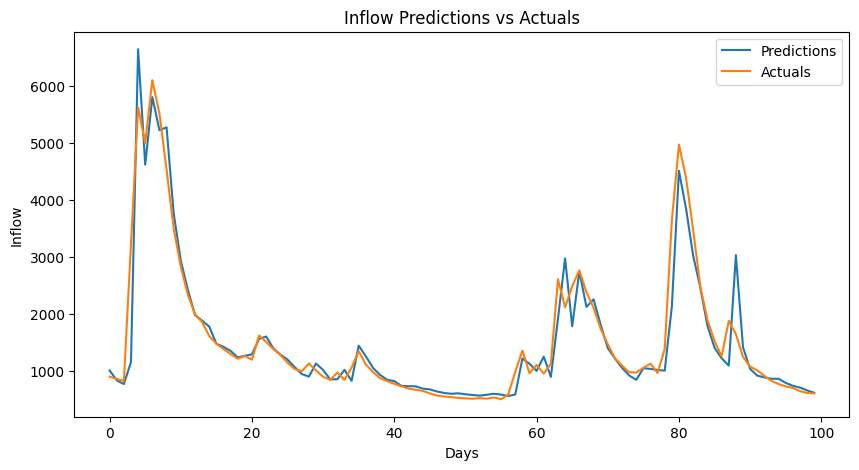

In [ ]:
start, end = 0, 100
plt.figure(figsize=(10, 5))
plt.plot(post_processed_df.index[start:end], post_processed_df['Inflow Predictions'][start:end], label='Predictions')
plt.plot(post_processed_df.index[start:end], post_processed_df['Inflow Actuals'][start:end], label='Actuals')

plt.xlabel("Days")
plt.ylabel("Inflow")
plt.title("Inflow Predictions vs Actuals")
plt.legend()

plt.show()

## LSTM flere lag

In [44]:
model5 = Sequential()
model5.add(InputLayer((6, 5)))
model5.add(LSTM(32, return_sequences=True))
model5.add(LSTM(16))
model5.add(Dense(8, 'relu'))
model5.add(Dense(1, 'linear'))

model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 6, 32)             4864      
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dense_8 (Dense)             (None, 8)                 136       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8145 (31.82 KB)
Trainable params: 8145 (31.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
cp5 = ModelCheckpoint('model5/', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [46]:
model5.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=50, callbacks=[cp5])

Epoch 1/50
180/188 [===========================>..] - ETA: 0s - loss: 0.4340 - root_mean_squared_error: 0.6588INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 4s 14ms/step - loss: 0.4283 - root_mean_squared_error: 0.6544 - val_loss: 0.1332 - val_root_mean_squared_error: 0.3650
Epoch 2/50
172/188 [==========================>...] - ETA: 0s - loss: 0.1333 - root_mean_squared_error: 0.3651INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 13ms/step - loss: 0.1311 - root_mean_squared_error: 0.3621 - val_loss: 0.0462 - val_root_mean_squared_error: 0.2149
Epoch 3/50
170/188 [==========================>...] - ETA: 0s - loss: 0.0837 - root_mean_squared_error: 0.2893INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 0.0838 - root_mean_squared_error: 0.2894 - val_loss: 0.0386 - val_root_mean_squared_error: 0.1965
Epoch 4/50
188/188 [==============================] - 0s 2ms/step - loss: 0.0759 - root_mean_squared_error: 0.2755 - val_loss: 0.0466 - val_root_mean_squared_error: 0.2159
Epoch 5/50
168/188 [=========================>....] - ETA: 0s - loss: 0.0741 - root_mean_squared_error: 0.2723INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 0.0727 - root_mean_squared_error: 0.2696 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1860
Epoch 6/50
176/188 [===========================>..] - ETA: 0s - loss: 0.0699 - root_mean_squared_error: 0.2644INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 14ms/step - loss: 0.0705 - root_mean_squared_error: 0.2655 - val_loss: 0.0328 - val_root_mean_squared_error: 0.1811
Epoch 7/50
180/188 [===========================>..] - ETA: 0s - loss: 0.0709 - root_mean_squared_error: 0.2663INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 0.0701 - root_mean_squared_error: 0.2647 - val_loss: 0.0316 - val_root_mean_squared_error: 0.1778
Epoch 8/50
188/188 [==============================] - 0s 2ms/step - loss: 0.0687 - root_mean_squared_error: 0.2621 - val_loss: 0.0373 - val_root_mean_squared_error: 0.1932
Epoch 9/50
172/188 [==========================>...] - ETA: 0s - loss: 0.0664 - root_mean_squared_error: 0.2578INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 13ms/step - loss: 0.0672 - root_mean_squared_error: 0.2593 - val_loss: 0.0311 - val_root_mean_squared_error: 0.1764
Epoch 10/50
182/188 [============================>.] - ETA: 0s - loss: 0.0656 - root_mean_squared_error: 0.2562INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 0.0668 - root_mean_squared_error: 0.2584 - val_loss: 0.0298 - val_root_mean_squared_error: 0.1725
Epoch 11/50
188/188 [==============================] - 0s 2ms/step - loss: 0.0662 - root_mean_squared_error: 0.2574 - val_loss: 0.0319 - val_root_mean_squared_error: 0.1787
Epoch 12/50
188/188 [==============================] - 0s 2ms/step - loss: 0.0663 - root_mean_squared_error: 0.2576 - val_loss: 0.0354 - val_root_mean_squared_error: 0.1881
Epoch 13/50
188/188 [==============================] - 0s 3ms/step - loss: 0.0645 - root_mean_squared_error: 0.2539 - val_loss: 0.0324 - val_root_mean_squared_error: 0.1799
Epoch 14/50
188/188 [==============================] - 0s 2ms/step - loss: 0.0650 - root_mean_squared_error: 0.2550 - val_loss: 0.0376 - val_root_mean_squared_error: 0.1940
Epoch 15/50
188/188 [==============================] - 0s 2ms/step - loss: 0.0645 - root_mean_squared_error: 0.2539 - val_loss: 0.0315 - val_root_

INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 0.0589 - root_mean_squared_error: 0.2426 - val_loss: 0.0293 - val_root_mean_squared_error: 0.1712
Epoch 31/50
188/188 [==============================] - 0s 2ms/step - loss: 0.0574 - root_mean_squared_error: 0.2395 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1958
Epoch 32/50
188/188 [==============================] - 0s 2ms/step - loss: 0.0575 - root_mean_squared_error: 0.2397 - val_loss: 0.0387 - val_root_mean_squared_error: 0.1968
Epoch 33/50
188/188 [==============================] - 0s 2ms/step - loss: 0.0571 - root_mean_squared_error: 0.2389 - val_loss: 0.0356 - val_root_mean_squared_error: 0.1886
Epoch 34/50
188/188 [==============================] - 0s 2ms/step - loss: 0.0563 - root_mean_squared_error: 0.2373 - val_loss: 0.0436 - val_root_mean_squared_error: 0.2089
Epoch 35/50
188/188 [==============================] - 0s 2ms/step - loss: 0.0559 - root_mean_squared_error: 0.2363 - val_loss: 0.0382 - val_root_

33/33 [==============================] - 1s 921us/step


(      Predictions   Actuals
 0       -0.414171 -0.449783
 1       -0.549210 -0.475209
 2       -0.577808 -0.493870
 3       -0.576927  0.943299
 4        3.257724  2.390679
 ...           ...       ...
 1024     1.838859  2.135681
 1025     1.441686  2.841083
 1026     2.081171  3.319088
 1027     2.259711  3.142837
 1028     2.091445  2.821145
 
 [1029 rows x 2 columns],
 0.25412038302645745)

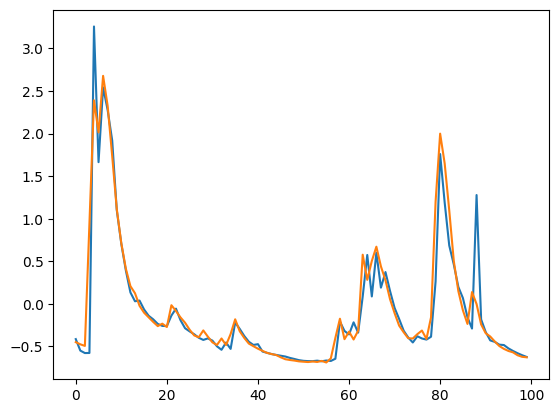

In [47]:
plot_predictions1(model5, X2_test, y2_test)

## Conv1d flere lag

In [48]:
model6 = Sequential()
model6.add(InputLayer((6, 5)))
model6.add(Conv1D(64, kernel_size=2, activation='relu'))
model6.add(Flatten())
model6.add(Dense(8, 'relu'))
model6.add(Dense(1, 'linear'))
model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 5, 64)             704       
                                                                 
 flatten_1 (Flatten)         (None, 320)               0         
                                                                 
 dense_10 (Dense)            (None, 8)                 2568      
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 3281 (12.82 KB)
Trainable params: 3281 (12.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
cp6 = ModelCheckpoint('model6/', save_best_only=True)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [50]:
model6.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=50, callbacks=[cp6])

Epoch 1/50
118/188 [=================>............] - ETA: 0s - loss: 0.2579 - root_mean_squared_error: 0.5079INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 1s 2ms/step - loss: 0.2089 - root_mean_squared_error: 0.4571 - val_loss: 0.0546 - val_root_mean_squared_error: 0.2336
Epoch 2/50
 95/188 [==============>...............] - ETA: 0s - loss: 0.0789 - root_mean_squared_error: 0.2810INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 1ms/step - loss: 0.0891 - root_mean_squared_error: 0.2985 - val_loss: 0.0484 - val_root_mean_squared_error: 0.2201
Epoch 3/50
102/188 [===============>..............] - ETA: 0s - loss: 0.0729 - root_mean_squared_error: 0.2700INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 1ms/step - loss: 0.0763 - root_mean_squared_error: 0.2762 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1944
Epoch 4/50
188/188 [==============================] - 0s 625us/step - loss: 0.0720 - root_mean_squared_error: 0.2683 - val_loss: 0.0660 - val_root_mean_squared_error: 0.2569
Epoch 5/50
 95/188 [==============>...............] - ETA: 0s - loss: 0.0731 - root_mean_squared_error: 0.2703INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 1ms/step - loss: 0.0708 - root_mean_squared_error: 0.2661 - val_loss: 0.0372 - val_root_mean_squared_error: 0.1928
Epoch 6/50
188/188 [==============================] - 0s 620us/step - loss: 0.0675 - root_mean_squared_error: 0.2597 - val_loss: 0.0406 - val_root_mean_squared_error: 0.2014
Epoch 7/50
188/188 [==============================] - 0s 644us/step - loss: 0.0652 - root_mean_squared_error: 0.2553 - val_loss: 0.0376 - val_root_mean_squared_error: 0.1940
Epoch 8/50
188/188 [==============================] - 0s 627us/step - loss: 0.0645 - root_mean_squared_error: 0.2540 - val_loss: 0.0399 - val_root_mean_squared_error: 0.1998
Epoch 9/50
 96/188 [==============>...............] - ETA: 0s - loss: 0.0637 - root_mean_squared_error: 0.2525INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 1ms/step - loss: 0.0641 - root_mean_squared_error: 0.2532 - val_loss: 0.0354 - val_root_mean_squared_error: 0.1880
Epoch 10/50
188/188 [==============================] - 0s 734us/step - loss: 0.0636 - root_mean_squared_error: 0.2523 - val_loss: 0.0356 - val_root_mean_squared_error: 0.1888
Epoch 11/50
188/188 [==============================] - 0s 634us/step - loss: 0.0629 - root_mean_squared_error: 0.2508 - val_loss: 0.0382 - val_root_mean_squared_error: 0.1954
Epoch 12/50
188/188 [==============================] - 0s 613us/step - loss: 0.0625 - root_mean_squared_error: 0.2500 - val_loss: 0.0360 - val_root_mean_squared_error: 0.1898
Epoch 13/50
188/188 [==============================] - 0s 623us/step - loss: 0.0622 - root_mean_squared_error: 0.2494 - val_loss: 0.0459 - val_root_mean_squared_error: 0.2142
Epoch 14/50
101/188 [===============>..............] - ETA: 0s - loss: 0.0611 - root_mean_squared_error: 0.2472INFO:tensorflow:Assets writt

INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 1ms/step - loss: 0.0624 - root_mean_squared_error: 0.2498 - val_loss: 0.0347 - val_root_mean_squared_error: 0.1863
Epoch 15/50
188/188 [==============================] - ETA: 0s - loss: 0.0597 - root_mean_squared_error: 0.2443INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 0.0597 - root_mean_squared_error: 0.2443 - val_loss: 0.0341 - val_root_mean_squared_error: 0.1846
Epoch 16/50
188/188 [==============================] - 0s 641us/step - loss: 0.0612 - root_mean_squared_error: 0.2474 - val_loss: 0.0465 - val_root_mean_squared_error: 0.2157
Epoch 17/50
188/188 [==============================] - 0s 661us/step - loss: 0.0600 - root_mean_squared_error: 0.2449 - val_loss: 0.0411 - val_root_mean_squared_error: 0.2028
Epoch 18/50
188/188 [==============================] - 0s 635us/step - loss: 0.0591 - root_mean_squared_error: 0.2432 - val_loss: 0.0365 - val_root_mean_squared_error: 0.1911
Epoch 19/50
 95/188 [==============>...............] - ETA: 0s - loss: 0.0673 - root_mean_squared_error: 0.2594INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 1ms/step - loss: 0.0591 - root_mean_squared_error: 0.2431 - val_loss: 0.0317 - val_root_mean_squared_error: 0.1780
Epoch 20/50
188/188 [==============================] - 0s 626us/step - loss: 0.0589 - root_mean_squared_error: 0.2427 - val_loss: 0.0362 - val_root_mean_squared_error: 0.1904
Epoch 21/50
188/188 [==============================] - 0s 609us/step - loss: 0.0583 - root_mean_squared_error: 0.2414 - val_loss: 0.0548 - val_root_mean_squared_error: 0.2341
Epoch 22/50
188/188 [==============================] - 0s 641us/step - loss: 0.0585 - root_mean_squared_error: 0.2420 - val_loss: 0.0384 - val_root_mean_squared_error: 0.1958
Epoch 23/50
188/188 [==============================] - 0s 662us/step - loss: 0.0577 - root_mean_squared_error: 0.2403 - val_loss: 0.0370 - val_root_mean_squared_error: 0.1924
Epoch 24/50
188/188 [==============================] - 0s 683us/step - loss: 0.0555 - root_mean_squared_error: 0.2356 - val_loss: 0.0356 - 

33/33 [==============================] - 0s 436us/step


(      Predictions   Actuals
 0       -0.306047 -0.449783
 1       -0.452347 -0.475209
 2       -0.430186 -0.493870
 3       -0.379072  0.943299
 4        3.680432  2.390679
 ...           ...       ...
 1024     2.034367  2.135681
 1025     1.728596  2.841083
 1026     2.774284  3.319088
 1027     2.921401  3.142837
 1028     2.518021  2.821145
 
 [1029 rows x 2 columns],
 0.25208309472801144)

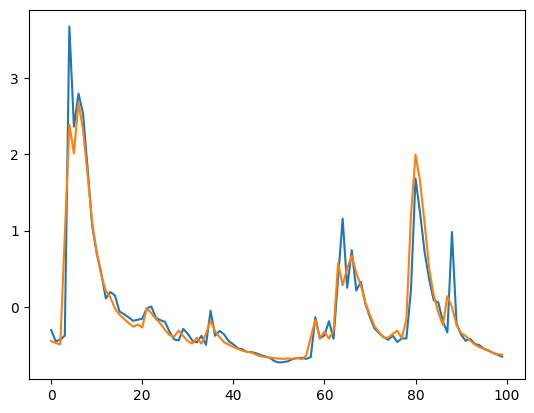

In [51]:
plot_predictions1(model6, X2_test, y2_test)

## Using forecasts